In [41]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns
import scipy.stats as st
import time
import os
import pickle

In [52]:
# Configurations
save_stats = True
save_figs = False

## 2. Q-Learning

In [43]:
def measure_performance(player_1, player_2, num_episodes = 500):
    """
    Measures performance of player 1 against player 2 (percentage of wins player 1)
    TODO
    """
    meas = 0
    turns = np.array(['X','O'])
    env = TictactoeEnv()
    for itr in range(num_episodes):
        env.reset()
        grid, _, _ = env.observe()
        player_1.set_player(turns[itr%2])
        player_2.set_player(turns[(itr+1)%2])
        while not env.end:
            if env.current_player == player_1.player:
                move = player_1.act(grid)
            else:
                move = player_2.act(grid)
            grid, _, _ = env.step(move, print_grid=False)
        meas += env.reward(player=player_1.player)
    return meas/num_episodes

def running_average(vec, windows_size = 250):
    idx = np.arange(0,len(vec),windows_size)
    return [np.sum(vec[i:i+windows_size])/windows_size for i in idx], idx + windows_size

def encode_state(state):
    return state.tobytes()

def available(grid):
    """
    TODO
    """
    avail_indices = []
    avail_mask = [False] * 9
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail_indices.append(i)
            avail_mask[i] = True
    return avail_indices, avail_mask

def epsilon_greedy_action(grid, Q, epsilon, num_actions = 9):
    """
    TODO
    """
    avail_indices, avail_mask = available(grid)

    if np.random.uniform(0,1) < epsilon:
        return avail_indices[np.random.randint(0, len(avail_indices))]
    else:
        q = Q[encode_state(grid)]
        q[np.logical_not(avail_mask)] = np.nan
        max_indices = np.argwhere(q == np.nanmax(q))
        return int(max_indices[np.random.randint(0, len(max_indices))])

class QPlayer:
    """
    TODO
    """
    def __init__(self, Q, player='X'):
        self.Q = Q
        self.player = player  # 'x' or 'O'

    def set_player(self, player='X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def act(self, grid, **kwargs):
        """
        TODO
        """
        return epsilon_greedy_action(grid, self.Q, 0)


def q_learning(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
               epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    if verbose:
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=turns[(itr+1) % 2])
        env.reset()
        state, _, _ = env.observe()
        # First step of the adversarial
        if env.current_player == player_opt.player:
            move = player_opt.act(state)
            state, _, _ = env.step(move)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr+1))
        while not env.end:
            next_state, _, _ = env.step(action)     # Move according to the policy
            if not env.end:
                move = player_opt.act(next_state)   # Adversarial move
                next_state, _, _ = env.step(move)
            # Sarsa update rule
            reward = env.reward(player=my_player)
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr+1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:
                target = reward
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])
            # Preparing for the next move
            state = next_state
            action = next_action

        episode_rewards[itr] = env.reward(player=my_player)

        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

### 2.1 Learning from experts

In [44]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000
epsilon_exploration = 0.01

Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=True)

Episode  0 :	M_opt =  -0.938 	M_rand =  0.026


KeyboardInterrupt: 

In [ ]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)

names = ['Optimal', 'Random', 'Trained']
players = [OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.), QPlayer(Q=Q)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)

#### 2.1.1 Decreasing exploration

In [ ]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
print(vec_n_star)
stats_dict_nstar = {}
for n_star in vec_n_star:
    print("------------- Training with n_star =", n_star, "-------------")
    def epsilon_exploration_rule(n):
        return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
    start = time.time()
    Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
    elapsed = time.time() - start
    print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def plot_stats(stats_dict, vec_var, var_name, var_legend_name, save = False):
    fig_reward, ax_reward = plt.subplots()
    fig_performance, ax = plt.subplots(1,2, figsize=(13.4,4.8))

    for var in vec_var:
        (stats, M_opt, M_rand) = stats_dict[var]
        # Plot of the average reward during training
        running_average_rewards, x_reward = running_average(stats['rewards'])
        ax_reward.plot(x_reward, running_average_rewards, label="$"+ var_legend_name +" = "+ str(var) +"$")
        # Plot of M_opt and M_rand during training
        x_performance = np.arange(0, len(stats['rewards'])+1, len(stats['rewards']) / (len(stats['test_Mopt']) - 1))
        ax[0].plot(x_performance, stats['test_Mopt'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        ax[1].plot(x_performance, stats['test_Mrand'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        print(var_name + " =", var,": \tM_opt = ", M_opt, "\tM_rand = ", M_rand)

    ax_reward.set_ylim([-1,1])
    ax_reward.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_title('Average reward during training')
    ax_reward.legend(loc='lower right')


    ax[0].hlines(y=0, xmin=x[0], xmax=x[-1], color='r', linestyle='--')
    ax[0].set_ylim([-1,0.1])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('$M_{opt}$')
    ax[0].set_title('$M_{opt}$ during training')
    ax[0].legend(loc='lower right')

    ax[1].set_ylim([-1,1])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('$M_{rand}$')
    ax[1].set_title('$M_{rand}$ during training')
    ax[1].legend(loc='lower right')
    plt.show()
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.png')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.png')

In [ ]:
plot_n_star = vec_n_star
plot_stats(stats_dict_nstar, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

#### 2.1.2 Good experts and bad experts

In [ ]:
n_star = 4000 # this should be picked from before not inserted manually
#vec_epsilon_opt = [0, 0.3, 0.5, 0.7, 1]
M = 10 # how much we want to stratify [0, 1]
# a reasonable choice for the epsilon vector here to me is
vec_epsilon_opt = np.hstack([np.array([0]), st.uniform.rvs(loc=np.arange(M) / M, scale=1/M), np.array([1])])
print(vec_epsilon_opt)
stats_dict_epsilon_opt = {}
for epsilon_opt in vec_epsilon_opt:
    print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
    start = time.time()
    Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
    elapsed = time.time() - start
    print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
plot_epsilon_opt = vec_epsilon_opt
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs)

### 2.2 Learning by self-practice

In [46]:
def q_learning_self_practice(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1,
                             epsilon_exploration_rule = None, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.empty(num_episodes)
    # Stats of training
    episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))]
    if verbose:
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        env.reset()
        state, _, _ = env.observe()
        # First two turns outside the loop (at least five turns are played)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr + 1))
        state_adv, _, _ = env.step(action)
        action_adv = epsilon_greedy_action(state_adv, Q, epsilon_exploration_rule(itr + 1))
        while not env.end:
            # Adversarial turn
            state_adv, _, _ = env.observe()
            reward = - env.reward(player=env.current_player)    # Reward of the player who made the last move
            next_state, _, _ = env.step(action_adv)
            # Player's turn
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr + 1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:   # action_adv is the one that makes the game end
                reward = - env.reward(player=env.current_player)    # reward of the player who made the game end, i.e. the adversary of the current player
                # Update for the adversary of the current player
                Q[encode_state(state_adv)][action_adv] += alpha * reward
                # Target for the current player
                target = - reward + gamma * Q[encode_state(next_state)][next_action]
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])

            # Preparing for the next iteration
            action = action_adv
            state = state_adv
            action_adv = next_action


        episode_rewards[itr] = env.reward(player=my_player)
        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats


    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

#### Question 7: Fixed $\epsilon$ first

In [47]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_vec = [0.1]
stats_dict_eps_self = {}
for epsilon in epsilon_vec:
    print("------------- Training with epsilon =", epsilon, "-------------")
    Q, stats = q_learning_self_practice(env, num_episodes=num_episodes,
                        epsilon_exploration=epsilon, test_freq = 250, verbose=True)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_eps_self.update({epsilon: (stats, M_opt, M_rand)})

if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_eps_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

------------- Training with epsilon = 0.1 -------------
Episode  0 :	M_opt =  -0.922 	M_rand =  0.026
Episode  250 :	M_opt =  -0.932 	M_rand =  0.19
Episode  500 :	M_opt =  -0.848 	M_rand =  0.232
Episode  750 :	M_opt =  -0.912 	M_rand =  0.216
Episode  1000 :	M_opt =  -0.954 	M_rand =  0.04
Episode  1250 :	M_opt =  -0.946 	M_rand =  0.44
Episode  1500 :	M_opt =  -0.942 	M_rand =  0.4
Episode  1750 :	M_opt =  -0.432 	M_rand =  0.51
Episode  2000 :	M_opt =  -0.77 	M_rand =  0.49
Episode  2250 :	M_opt =  -0.774 	M_rand =  0.412
Episode  2500 :	M_opt =  -0.826 	M_rand =  0.438
Episode  2750 :	M_opt =  -0.6 	M_rand =  0.616
Episode  3000 :	M_opt =  -0.45 	M_rand =  0.6
Episode  3250 :	M_opt =  -0.478 	M_rand =  0.576
Episode  3500 :	M_opt =  -0.562 	M_rand =  0.588
Episode  3750 :	M_opt =  -0.466 	M_rand =  0.678
Episode  4000 :	M_opt =  -0.734 	M_rand =  0.776
Episode  4250 :	M_opt =  -0.744 	M_rand =  0.678
Episode  4500 :	M_opt =  -0.262 	M_rand =  0.782
Episode  4750 :	M_opt =  -0.224 

epsilon = 0.1 : 	M_opt =  0.0 	M_rand =  0.931


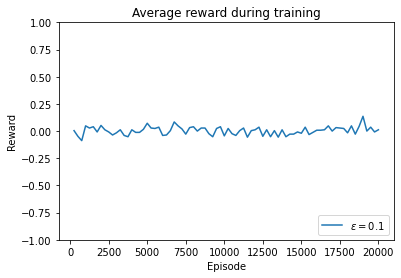

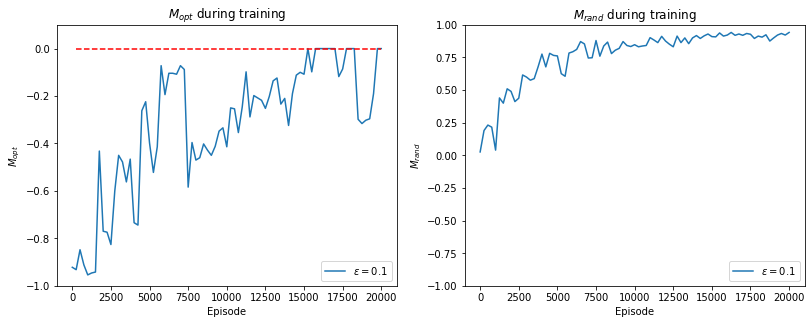

In [48]:
plot_stats(stats_dict_eps_self, epsilon_vec, "epsilon_self", "\epsilon", save=save_figs)

#### Question 8: Changing exploration rule, $\epsilon$ decay

In [49]:
vec_n_star = [5000]
epsilon_min = 0.1
epsilon_max = 0.8
stats_dict_nstar_self = {}
for n_star in vec_n_star:
    print("------------- Training with n_star =", n_star, "-------------")
    def epsilon_exploration_rule(n):
        return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
    start = time.time()
    Q, stats = q_learning_self_practice(env, epsilon_exploration_rule=epsilon_exploration_rule,
                                        test_freq=test_freq,  num_episodes=num_episodes, verbose=True)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=200)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=200)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_nstar_self.update({n_star: (stats, M_opt, M_rand)})
    elapsed = time.time() - start
    print("Training with n_star =", n_star, "took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), "\n\n")

if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_self, handle, protocol=pickle.HIGHEST_PROTOCOL)

------------- Training with n_star = 5000 -------------
Episode  0 :	M_opt =  -0.922 	M_rand =  -0.036
Episode  250 :	M_opt =  -0.92 	M_rand =  0.106
Episode  500 :	M_opt =  -0.942 	M_rand =  0.046
Episode  750 :	M_opt =  -0.91 	M_rand =  0.166
Episode  1000 :	M_opt =  -0.9 	M_rand =  0.256
Episode  1250 :	M_opt =  -0.83 	M_rand =  0.4
Episode  1500 :	M_opt =  -0.932 	M_rand =  0.278
Episode  1750 :	M_opt =  -0.884 	M_rand =  0.412
Episode  2000 :	M_opt =  -0.92 	M_rand =  0.448
Episode  2250 :	M_opt =  -0.948 	M_rand =  0.474
Episode  2500 :	M_opt =  -0.852 	M_rand =  0.576
Episode  2750 :	M_opt =  -0.63 	M_rand =  0.584
Episode  3000 :	M_opt =  -1.0 	M_rand =  0.486
Episode  3250 :	M_opt =  -0.868 	M_rand =  0.568
Episode  3500 :	M_opt =  -0.658 	M_rand =  0.642
Episode  3750 :	M_opt =  -0.792 	M_rand =  0.606
Episode  4000 :	M_opt =  -0.538 	M_rand =  0.616
Episode  4250 :	M_opt =  -0.204 	M_rand =  0.694
Episode  4500 :	M_opt =  -0.052 	M_rand =  0.796
Episode  4750 :	M_opt =  -0.7

n_star = 5000 : 	M_opt =  0.0 	M_rand =  0.91


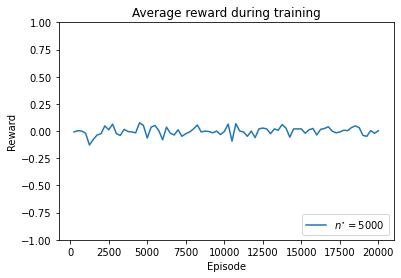

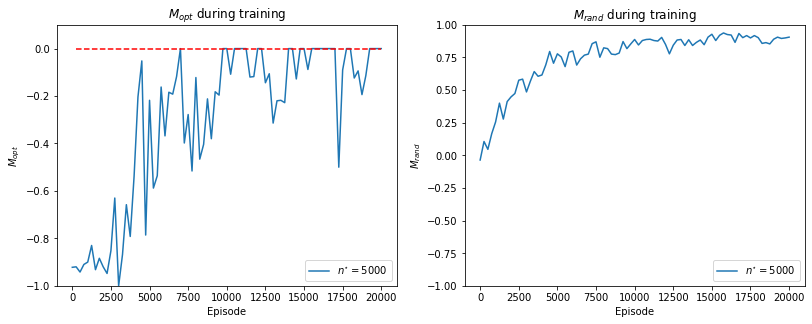

In [51]:
plot_stats(stats_dict_nstar_self, vec_n_star, "n_star_self", "n^{\star}", save=save_figs)

#### Question 9: TODO look for optimal $M_{opt}$ and $M_{rand}$

In [ ]:
### look for optimal values of M_opt and M_rand

#### Question 10: heat maps in 3 different states

In [ ]:
def heatmaps_subplots(grids, Q):
    fig, ax = plt.subplots(1, grids.shape[0], sharex='col', figsize=(10, 5))
    plt.subplots_adjust(wspace=0.5)
    for i in range(grids.shape[0]):
        df = Q[encode_state(grids[i, :])][:]
        df = np.reshape(df, (3, 3))
        sns.heatmap(df, annot=True, linewidths=.5, ax=ax[i])

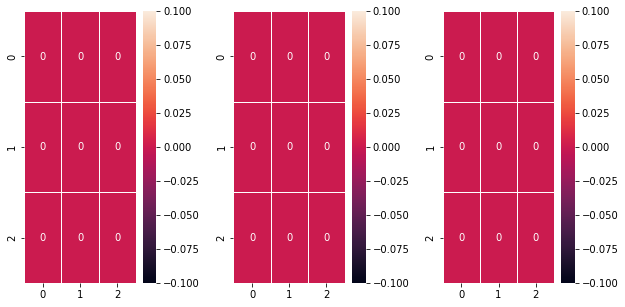

In [53]:
grids = np.array([[1, 0, -1, 1, -1, 1, 1, -1, 1], [1, -1, 1, 0, 0, 1, 0, -1, -1], [0, -1, 1, 0, 0, 1, 0, 0, -1]])
heatmaps_subplots(grids, Q)

## Deep Q-Learning